In [22]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

In [84]:
def get_bgr_frequencies(image):
    hist = {'red': [0] * 256, 'green': [0] * 256, 'blue': [0] * 256}
    for row in image:
        for pixel in row:
            hist['red'][pixel[2]] += 1
            hist['green'][pixel[1]] += 1
            hist['blue'][pixel[0]] += 1
    return hist

def get_hsi_frequencies(image):
    hist = {'hue': [0] * 256, 'saturation': [0] * 256, 'intensity': [0] * 256}
    for row in image:
        for pixel in row:
            hist['hue'][int(pixel[0]* 255 /360)] += 1
            hist['saturation'][int(pixel[1] * 255)] += 1
            hist['intensity'][int(pixel[2] * 255)] += 1
    return hist

def plot_rgb_freq(freqs, save=False, save_path_name=None):
    plt.plot(freqs['red'], color='red',label='Red')
    plt.plot(freqs['green'], color='green',label='Green')
    plt.plot(freqs['blue'], color='blue',label='Blue')
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)

def plot_hsi_freq(freqs, save=False, save_path_name=None):
    plt.plot(freqs['hue'], color='red', label='Hue')
    plt.plot(freqs['saturation'], color='green', label='Saturation')
    plt.plot(freqs['intensity'], color='blue', label='Intensity')
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)

def histo_mse(hist1, histo2):
    mse = 0
    for i in range(256):
        mse += (hist1['red'][i] - histo2['red'][i])**2
        mse += (hist1['green'][i] - histo2['green'][i])**2
        mse += (hist1['blue'][i] - histo2['blue'][i])**2
    return np.sqrt(mse)


def deg_to_rad(deg):
    return deg * np.pi / 180.0

'''
def bgr_to_hsi(bgr_image):
    with np.errstate(divide='ignore', invalid='ignore'):
        B = np.squeeze(bgr_image[..., 0])
        G = np.squeeze(bgr_image[..., 1])
        R = np.squeeze(bgr_image[..., 2])

        I = (R + G + B) / 3.0
        S = 1 - (3 / (R + G + B + 0.001) * np.minimum(np.minimum(R, G), B))
        H = np.zeros_like(I)

        m,n = B.shape
        for i in range(m):
            for j in range(n):
                H[i,j] = 0.5 * ((R[i,j] - G[i,j]) + (R[i,j] - B[i,j])) / np.sqrt((R[i,j] - G[i,j])**2 + (R[i,j] - B[i,j]) * (G[i,j] - B[i,j]))
                H[i,j] = np.arccos(H[i,j])
                if B[i,j] <= G[i,j]:
                    H[i,j] = 2 * np.pi - H[i,j]

        return np.dstack((H, S, I))
'''

def bgr_to_hsi(bgr_image):

    bgr_image = bgr_image.astype('float') / 255.0
    blue, green, red = bgr_image[..., 0], bgr_image[..., 1], bgr_image[..., 2]

    intensity = np.divide(blue + green + red, 3)

    min_color = np.minimum(np.minimum(red, green), blue)
    if (intensity.all() == 0):
        saturation = 0
    else:
        saturation = 1 - (3 / (red + green + blue + 0.001) * min_color)  # Adding 0.001 to avoid division by zero

    hue = np.arccos((0.5 * ((red - green) + (red - blue))) / np.sqrt((red - green)**2 + (red - blue) * (green - blue) + 0.000001))  # Adding 0.000001 to avoid division by zero
    hue[blue > green] = 2 * np.pi - hue[blue > green]

    hue = np.degrees(hue)

    hsi = np.dstack((hue, saturation, intensity))

    return hsi

def hsi_to_bgr(hsi_image):
    H = hsi_image[..., 0]
    S = hsi_image[..., 1]
    I = hsi_image[..., 2]

    B = I * (1 - S)
    R = I * (1 + S * np.cos(H) / np.cos(np.pi / 3 - H))
    G = 3 * I - (R + B)

    indices = np.where((H >= 2*np.pi/3) & (H < 4*np.pi/3))
    H[indices] = H[indices] - 2 * np.pi / 3
    R[indices] = I[indices] * (1 - S[indices])
    G[indices] = I[indices] * (1 + S[indices] * np.cos(H[indices]) / np.cos(np.pi / 3 - H[indices]))
    B[indices] = 3*I[indices] - (R[indices] + G[indices])

    indices = np.where(H >= 4*np.pi/3)
    H[indices] = H[indices] - 4 * np.pi / 3
    G[indices] = I[indices] * (1 - S[indices])
    B[indices] = I[indices] * (1 + S[indices] * np.cos(H[indices]) / np.cos(np.pi / 3 - H[indices]))
    R[indices] = 3*I[indices] - (B[indices] + G[indices])

    return np.dstack((B, G, R))

def show_bgr_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [63]:

#video = cv2.VideoCapture('./data/WSC.mp4')
image_o = cv2.imread('./data/WSC sample.png')
image = image_o.copy()

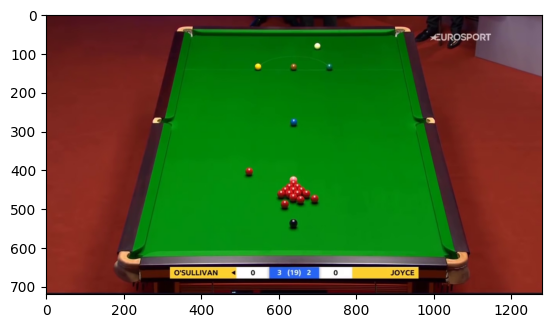

In [64]:
show_bgr_image(image)

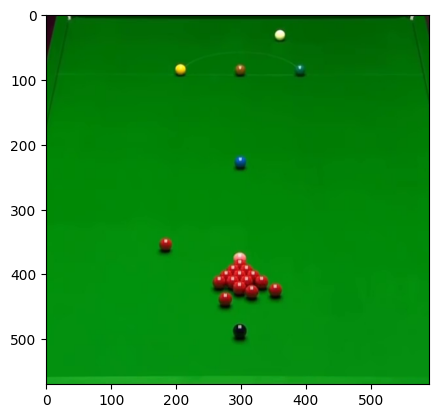

In [65]:
show_bgr_image(image[50:620, 340:930,:])

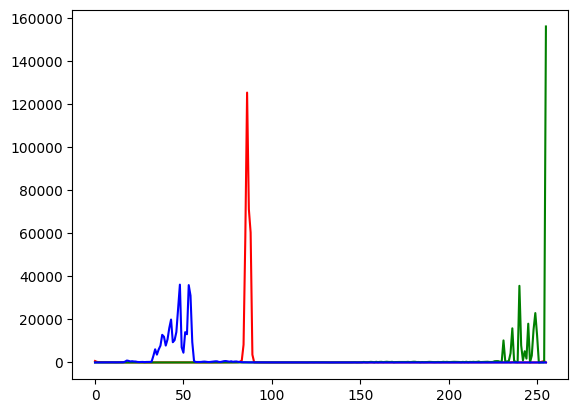

In [85]:
hsi_image = bgr_to_hsi(image[50:620, 340:930,:])
# plot the curve for H,S,I frequencies
hsi_freqs = get_hsi_frequencies(hsi_image)
plot_hsi_freq(hsi_freqs)

In [28]:
# create a mask the whitens green parts of the image and blackes the rest
mask = np.zeros(image.shape[:2], dtype='uint8')
mask[image[:,:,1] > 100] = 255
mask = cv2.bitwise_not(mask)
#save image
cv2.imwrite('./mask.png', mask)


True

In [20]:
# load the video form ./data/WSC.mp4
video = cv2.VideoCapture('./data/WSC.mp4')

# calculate the number of frames in the video
number_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

ret, frame = video.read()

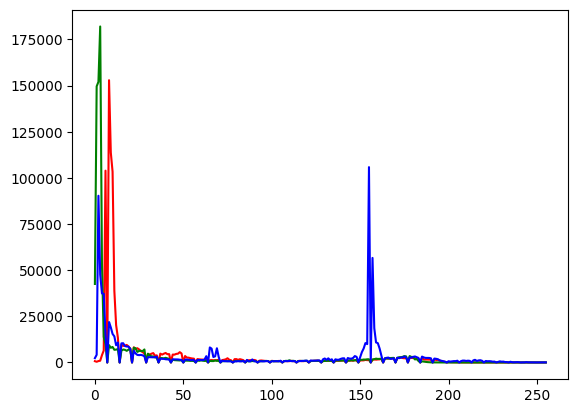

In [21]:
hist2 = get_image_histogram(frame)
plot_rgb_hist(hist2, save=False)

In [24]:
histo_mse(hist, hist2)

444414.0626397864